In [23]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [11]:
import struct

def load_mnist_images(filename):
    """Loads MNIST images from the given IDX file."""
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, 28, 28)
    return images


In [12]:
def load_mnist_labels(filename):
    """Loads MNIST labels from the given IDX file."""
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels


In [16]:
os.chdir("mnist_data")

In [18]:
# Load training set
train_images = load_mnist_images("train-images.idx3-ubyte")
train_labels = load_mnist_labels("train-labels.idx1-ubyte")

# Load test set
test_images = load_mnist_images("t10k-images.idx3-ubyte")
test_labels = load_mnist_labels("t10k-labels.idx1-ubyte")

print(f"Training set: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Test set: {test_images.shape}, Labels: {test_labels.shape}")


Training set: (60000, 28, 28), Labels: (60000,)
Test set: (10000, 28, 28), Labels: (10000,)


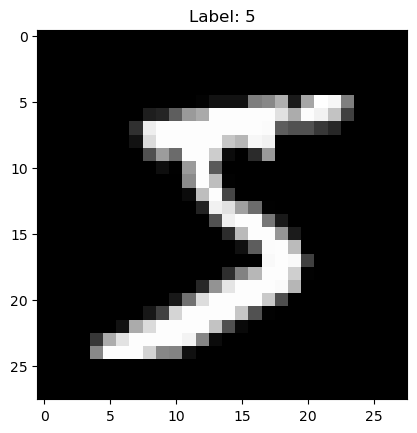

In [24]:
# Show the first image in the training set
plt.imshow(train_images[0], cmap="gray")
plt.title(f"Label: {train_labels[0]}")
plt.show()


In [25]:
# Convert images and labels to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1) / 255.0  # Normalize to [0,1]
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

test_images_tensor = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1) / 255.0  # Normalize
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

print(f"Train images tensor: {train_images_tensor.shape}")
print(f"Test images tensor: {test_images_tensor.shape}")


Train images tensor: torch.Size([60000, 1, 28, 28])
Test images tensor: torch.Size([10000, 1, 28, 28])


In [26]:
from torch.utils.data import Dataset, DataLoader

class MNISTDataset(Dataset):  # Inherit from PyTorch Dataset
    def __init__(self, images, labels):
        self.images = images  # Store image tensors
        self.labels = labels  # Store label tensors

    def __len__(self):
        return len(self.labels)  # Returns the number of samples

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]  # Retrieve image-label pair


In [27]:
# Create PyTorch datasets
train_dataset = MNISTDataset(train_images_tensor, train_labels_tensor)
test_dataset = MNISTDataset(test_images_tensor, test_labels_tensor)


In [28]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in test_loader: {len(test_loader)}")


Total batches in train_loader: 938
Total batches in test_loader: 157


In [29]:
for images, labels in train_loader:
    print(f"Batch size: {images.shape}, Labels: {labels.shape}")
    break  # Show only the first batch


Batch size: torch.Size([64, 1, 28, 28]), Labels: torch.Size([64])


In [30]:
import torch.nn as nn
import torch.nn.functional as F

# Define the neural network
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Fully connected layer 1
        self.fc2 = nn.Linear(128, 64)     # Fully connected layer 2
        self.fc3 = nn.Linear(64, 10)      # Output layer (10 classes)
        self.relu = nn.ReLU()             # Activation function

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten 28x28 images into 1D
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for output (will use CrossEntropyLoss)
        return x


In [31]:
import torch.optim as optim

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, and optimizer
model = MNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Using device: {device}")


Using device: cpu


In [32]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

print("Training complete!")


Epoch 1/5, Loss: 0.3435448556304423
Epoch 2/5, Loss: 0.14211208704731929
Epoch 3/5, Loss: 0.09779515377442434
Epoch 4/5, Loss: 0.07328522081143343
Epoch 5/5, Loss: 0.056540396100015385
Training complete!


In [33]:
correct = 0
total = 0
model.eval()  # Set model to evaluation mode

with torch.no_grad():  # No need to compute gradients
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted label
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 97.43%


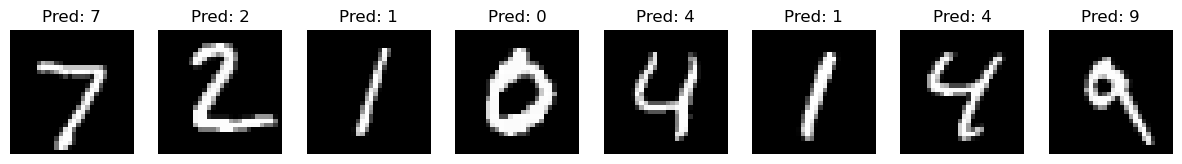

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test images
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

# Get model predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Convert tensor to NumPy for visualization
images = images.cpu().numpy()

# Plot 8 images with their predictions
fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    axes[i].imshow(images[i].squeeze(), cmap="gray")
    axes[i].set_title(f"Pred: {predicted[i].item()}")
    axes[i].axis("off")

plt.show()
